In [ ]:
pip install qutip

In [ ]:
#setup the matplotlib graphics library and configure it to show
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
# make qutip available in the rest of the notebook
from qutip import *
from matplotlib import animation as animation, pyplot as plt, cm
from IPython import display
from IPython.display import HTML
from scipy.integrate import simpson

In [ ]:
def pulse_on(t_p,wm,psi,c_ops,nsteps): # Hamiltonian when pulse is on
    psi0=psi

    tlist=linspace(0,t_p,nsteps)

    H_pulse_on= - 0.5*Delta * (1-sz)+ f * sx -0.5*g * (ad+a)* (1-sz) +wm * ad * a
    H_ener=-0.5*Delta * (1-sz)-0.5*g * (ad+a)* (sz-1) +wm * ad * a


    output=mesolve(H_pulse_on, psi0, tlist, c_ops, [])
    exp_vals=mesolve(H_pulse_on, psi0, tlist, c_ops, [nm, z,ns,sx,sy, H_pulse_on,Hdot_eff])
    dwork=[0]

    phonon=exp_vals.expect[0]
    motion=exp_vals.expect[1]
    spin=exp_vals.expect[2]
    spinx=exp_vals.expect[3]
    spiny=exp_vals.expect[4]
    energy_qm=exp_vals.expect[5]

    Heff_dot=exp_vals.expect[6]


    psi_list=output.states
    psi_out=psi_list[-1]




    G2 = correlation_3op_1t(H_pulse_on, psi, tlist, c_ops, ad, ad*a, a)
    g2 = G2


    return psi_out,phonon,motion,spin,spinx,spiny,g2,energy_qm


def pulse_off(t_free,wm,psi,c_ops,nsteps): #Hamiltonian when pulse is off
    psi0=psi

    tlist=linspace(0,t_free,nsteps)

    H_pulse_off= -0.5*Delta * (1-sz) -0.5*g * (ad+a)*(1-sz)+wm * ad * a


    output=mesolve(H_pulse_off, psi0, tlist, c_ops, [])
    exp_vals=mesolve(H_pulse_off, psi0, tlist, c_ops, [nm, z, ns,sx,sy, H_pulse_off,Hdot_eff])

    phonon=exp_vals.expect[0]
    motion=exp_vals.expect[1]
    spin=exp_vals.expect[2]
    spinx=exp_vals.expect[3]
    spiny=exp_vals.expect[4]
    psi_list=output.states
    psi_out=psi_list[-1]
    energy_qm=exp_vals.expect[5]
    Heff_dot=exp_vals.expect[6]



    G2 = correlation_3op_1t(H_pulse_off, psi, tlist, c_ops, ad, ad*a, a)
    g2 =G2

    return psi_out,phonon,motion,spin,spinx,spiny,g2,energy_qm


0.20000000476378968
0
0.19999997721447427
1


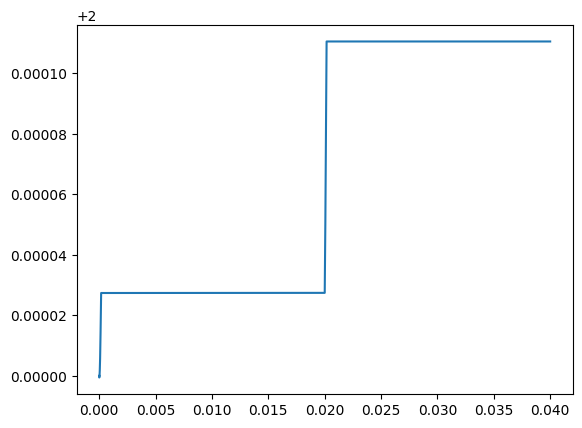

In [ ]:
#charging
n_list=1
gamma_list=linspace(1,6,n_list)
Phonon_increase=zeros(n_list)
alpha_increase=zeros(n_list)
Ph_stored=zeros(n_list)

for zeta in range (n_list):

    N=45

    # operators
    a  = tensor(destroy(N), qeye(2))
    ad = a.dag()
    sm = tensor(qeye(N), destroy(2))
    sp = tensor(qeye(N), create(2))
    sx = tensor(qeye(N), sigmax())
    sy = tensor(qeye(N), sigmay())
    sz = tensor(qeye(N), sigmaz())
    nm = ad * a
    ns = -0.5*(1-sz) #sm.dag() * sm


    # number f cavity fock states
    n_th_a = 2  # avg number of thermal bath excitation
    sp_th_a= 1*10**(-4)

    Gammae = 28e9
    gammam =1/(1*10000)

    gammas = 1/ (2.5*10**(-3))
    gammaa = 1/(5*10**(-3))
    gamma_l = 1/(1*10**(-6))

    c_ops1 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sp)


    c_ops2 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sp)

    #lasing
    rate = gamma_l
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)


    Delta = 0
    wm1 =  50  * 2 * pi
    wm2=wm1
    g  =  0.108*wm1
    f = 0.2*pi*1e7
    z = 1e-8 *(a + ad) #/sqrt(uu)
    z2 = z**2
    Hdot_eff=1j*g*wm1*(ad-a)

    #the final code
    t_p=pi/(2*abs(f))
    t_lase=1*10**(-5)
    kk=128

    t_free= 2*pi/(kk*wm1)
    t_free2= 2*(pi/wm1)-t_free- t_p-t_lase
    t_lase=1*10**(-5)
    psi_in = tensor(thermal_dm(N, n_th_a), ket2dm(basis(2, 0)))
    Ph=[n_th_a]
    Sp=[0]
    Sxm=[0]
    Sym=[0]
    Z_m=[0]
    t=[0]
    time_fac=0
    Entropy=[0]
    E_qm=[0]
    g2=[2]
    dW=[0]
    W=[0]




    ntimes=2#ntimes=1 is for single kick. ntimes>1 is for periodic kick


    for i in range(ntimes):

        #psi=psi_in.ptrace(0)
        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))
        psi=psi_in.ptrace(0)
        psi=psi_in.ptrace(0)
        psi_2=psi**2
        trace_=psi_2.tr()
        print(trace_)

        n1=200
        step1=pulse_on(t_p,wm1,psi_in,c_ops1,n1)


        Ph=hstack((Ph,step1[1][1:]))
        Z_m=hstack((Z_m,step1[2][1:]))
        Sp=hstack((Sp,step1[3][1:]))
        Sxm=hstack((Sxm,step1[4][1:]))
        Sym=hstack((Sym,step1[5][1:]))
        g2=hstack((g2,step1[6][1:]))
        E_qm=hstack((E_qm,step1[7][1:]))


        tlist=linspace(0,abs(t_p),n1)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_p


        psi_in=step1[0]
        psi=psi_in.ptrace(0)

        #free evolution of spin
        n2=1000

        step2=pulse_off((t_free),wm1,psi_in,c_ops1,n2)

        Ph=hstack((Ph,step2[1][1:]))
        Z_m=hstack((Z_m,step2[2][1:]))
        Sp=hstack((Sp,step2[3][1:]))
        Sxm=hstack((Sxm,step2[4][1:]))
        Sym=hstack((Sym,step2[5][1:]))
        g2=hstack((g2,step2[6][1:]))
        E_qm=hstack((E_qm,step2[7][1:]))

        tlist=linspace(0,t_free,n2)+time_fac
        t=hstack((t,tlist[1:]))


        time_fac=time_fac+t_free


        psi_in=step2[0]

        n3=200

        step3=pulse_off(t_lase,wm1,psi_in,c_ops2,n3)

        Ph=hstack((Ph,step3[1][1:]))
        Z_m=hstack((Z_m,step3[2][1:]))
        Sp=hstack((Sp,step3[3][1:]))
        Sxm=hstack((Sxm,step3[4][1:]))
        Sym=hstack((Sym,step3[5][1:]))
        g2=hstack((g2,step3[6][1:]))
        E_qm=hstack((E_qm,step3[7][1:]))

        tlist=linspace(0,t_lase,n3)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_lase

        psi_in=step3[0]
        psi=psi_in.ptrace(0)


        n4=1000


        step4=pulse_off(t_free2,wm1,psi_in,c_ops2,n4)

        Ph=hstack((Ph,step4[1][1:]))
        Z_m=hstack((Z_m,step4[2][1:]))
        Sp=hstack((Sp,step4[3][1:]))
        Sxm=hstack((Sxm,step4[4][1:]))
        Sym=hstack((Sym,step4[5][1:]))
        g2=hstack((g2,step4[6][1:]))
        E_qm=hstack((E_qm,step4[7][1:]))


        tlist=linspace(0,t_free2,n4)+time_fac
        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_free2

        psi_in=step4[0]
        psi=psi_in.ptrace(0)


        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))



        print(i)

    Phonon_increase[zeta]=Ph[-1]

    alpha_increase[zeta]=abs(Sym[-1])

    plt.plot(t,Ph)

0.19999993663990925
0


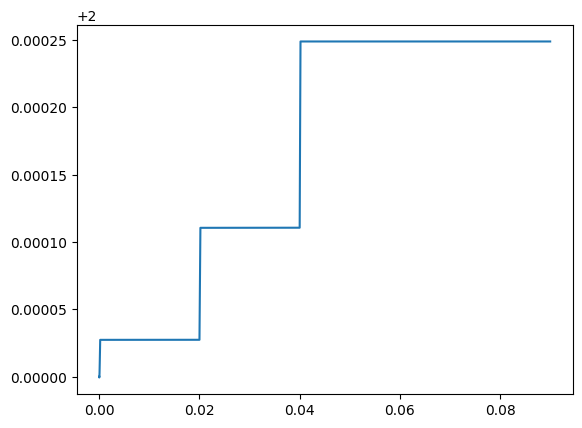

In [ ]:
#charging
n_list=1
gamma_list=linspace(1,6,n_list)
Phonon_increase=zeros(n_list)
alpha_increase=zeros(n_list)
Ph_stored=zeros(n_list)

for zeta in range (n_list):

    N=45

    # operators
    a  = tensor(destroy(N), qeye(2))
    ad = a.dag()
    sm = tensor(qeye(N), destroy(2))
    sp = tensor(qeye(N), create(2))
    sx = tensor(qeye(N), sigmax())
    sy = tensor(qeye(N), sigmay())
    sz = tensor(qeye(N), sigmaz())
    nm = ad * a
    ns = -0.5*(1-sz) #sm.dag() * sm


    # number f cavity fock states
    n_th_a = 2  # avg number of thermal bath excitation
    sp_th_a= 1*10**(-4)

    Gammae = 28e9
    gammam =1/(1*10000)

    gammas = 1/ (2.5*10**(-3))
    gammaa = 1/(5*10**(-3))
    gamma_l = 1/(1*10**(-6))

    c_ops1 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sp)


    c_ops2 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sp)

    #lasing
    rate = gamma_l
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)


    Delta = 0
    wm1 =  50  * 2 * pi
    wm2=wm1
    g  =  0.108*wm1
    f = 0.2*pi*1e7
    z = 1e-8 *(a + ad) #/sqrt(uu)
    z2 = z**2
    Hdot_eff=1j*g*wm1*(ad-a)

    #the final code
    t_p=pi/(2*abs(f))
    t_lase=1*10**(-5)
    kk=128

    t_free= 2*pi/(kk*wm1)
    t_free2= 5*(pi/wm1)-t_free- t_p-t_lase
    t_lase=1*10**(-5)

    Entropy=[0]
    E_qm=[0]
    g2=[2]
    dW=[0]
    W=[0]




    ntimes=1#ntimes=1 is for single kick. ntimes>1 is for periodic kick


    for i in range(ntimes):

        #psi=psi_in.ptrace(0)
        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))
        psi=psi_in.ptrace(0)
        psi=psi_in.ptrace(0)
        psi_2=psi**2
        trace_=psi_2.tr()
        print(trace_)

        n1=200
        step1=pulse_on(t_p,wm1,psi_in,c_ops1,n1)


        Ph=hstack((Ph,step1[1][1:]))
        Z_m=hstack((Z_m,step1[2][1:]))
        Sp=hstack((Sp,step1[3][1:]))
        Sxm=hstack((Sxm,step1[4][1:]))
        Sym=hstack((Sym,step1[5][1:]))
        g2=hstack((g2,step1[6][1:]))
        E_qm=hstack((E_qm,step1[7][1:]))


        tlist=linspace(0,abs(t_p),n1)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_p


        psi_in=step1[0]
        psi=psi_in.ptrace(0)

        #free evolution of spin
        n2=1000

        step2=pulse_off((t_free),wm1,psi_in,c_ops1,n2)

        Ph=hstack((Ph,step2[1][1:]))
        Z_m=hstack((Z_m,step2[2][1:]))
        Sp=hstack((Sp,step2[3][1:]))
        Sxm=hstack((Sxm,step2[4][1:]))
        Sym=hstack((Sym,step2[5][1:]))
        g2=hstack((g2,step2[6][1:]))
        E_qm=hstack((E_qm,step2[7][1:]))

        tlist=linspace(0,t_free,n2)+time_fac
        t=hstack((t,tlist[1:]))


        time_fac=time_fac+t_free


        psi_in=step2[0]

        n3=200

        step3=pulse_off(t_lase,wm1,psi_in,c_ops2,n3)

        Ph=hstack((Ph,step3[1][1:]))
        Z_m=hstack((Z_m,step3[2][1:]))
        Sp=hstack((Sp,step3[3][1:]))
        Sxm=hstack((Sxm,step3[4][1:]))
        Sym=hstack((Sym,step3[5][1:]))
        g2=hstack((g2,step3[6][1:]))
        E_qm=hstack((E_qm,step3[7][1:]))

        tlist=linspace(0,t_lase,n3)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_lase

        psi_in=step3[0]
        psi=psi_in.ptrace(0)


        n4=1000


        step4=pulse_off(t_free2,wm1,psi_in,c_ops2,n4)

        Ph=hstack((Ph,step4[1][1:]))
        Z_m=hstack((Z_m,step4[2][1:]))
        Sp=hstack((Sp,step4[3][1:]))
        Sxm=hstack((Sxm,step4[4][1:]))
        Sym=hstack((Sym,step4[5][1:]))
        g2=hstack((g2,step4[6][1:]))
        E_qm=hstack((E_qm,step4[7][1:]))


        tlist=linspace(0,t_free2,n4)+time_fac
        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_free2

        psi_in=step4[0]
        psi=psi_in.ptrace(0)


        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))



        print(i)

    Phonon_increase[zeta]=Ph[-1]

    alpha_increase[zeta]=abs(Sym[-1])

    plt.plot(t,Ph)

0.19999981630293112
0
0.19999976958228996
1
0.1999996895247048
2


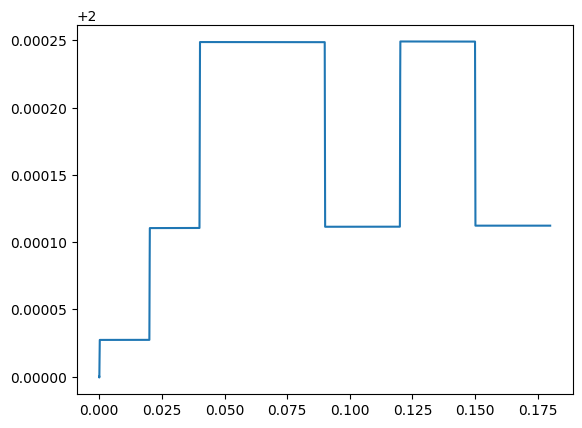

In [ ]:
#discharging
n_list=1
gamma_list=linspace(1,6,n_list)
Phonon_increase=zeros(n_list)
alpha_increase=zeros(n_list)
Ph_stored=zeros(n_list)

for zeta in range (n_list):

    N=45

    # operators
    a  = tensor(destroy(N), qeye(2))
    ad = a.dag()
    sm = tensor(qeye(N), destroy(2))
    sp = tensor(qeye(N), create(2))
    sx = tensor(qeye(N), sigmax())
    sy = tensor(qeye(N), sigmay())
    sz = tensor(qeye(N), sigmaz())
    nm = ad * a
    ns = -0.5*(1-sz) #sm.dag() * sm


    # number f cavity fock states
    n_th_a = 2  # avg number of thermal bath excitation
    sp_th_a= 1*10**(-4)

    Gammae = 28e9
    gammam =1/(1*10000)

    gammas = 1/ (2.5*10**(-3))
    gammaa = 1/(5*10**(-3))
    gamma_l = 1/(1*10**(-6))

    c_ops1 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops1.append(sqrt(rate) * sp)


    c_ops2 = []
    # cavity relaxation
    rate = gammam * (1 + n_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a)
    # cavity excitation, if temperature > 0
    rate = gammam * n_th_a
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * a.dag())
    # qubit relaxation
    rate = gammas
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sz)
    rate = gammaa*(1+sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)
    rate = gammaa*(sp_th_a)
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sp)

    #lasing
    rate = gamma_l
    if rate > 0.0:
        c_ops2.append(sqrt(rate) * sm)


    Delta = 0
    wm1 =  50  * 2 * pi
    wm2=wm1
    g  =  0.108*wm1
    f = 0.2*pi*1e7
    z = 1e-8 *(a + ad) #/sqrt(uu)
    z2 = z**2
    Hdot_eff=1j*g*wm1*(ad-a)

    #the final code
    t_p=pi/(2*abs(f))
    t_lase=1*10**(-5)
    kk=128

    t_free= 2*pi/(kk*wm1)
    t_free2= 2*(pi/wm1)-t_free- t_p-t_lase
    t_lase=1*10**(-5)

    Entropy=[0]
    E_qm=[0]
    g2=[2]
    dW=[0]
    W=[0]




    ntimes=3#ntimes=1 is for single kick. ntimes>1 is for periodic kick


    for i in range(ntimes):

        #psi=psi_in.ptrace(0)
        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))
        psi=psi_in.ptrace(0)
        psi=psi_in.ptrace(0)
        psi_2=psi**2
        trace_=psi_2.tr()
        print(trace_)

        n1=200
        step1=pulse_on(t_p,wm1,psi_in,c_ops1,n1)


        Ph=hstack((Ph,step1[1][1:]))
        Z_m=hstack((Z_m,step1[2][1:]))
        Sp=hstack((Sp,step1[3][1:]))
        Sxm=hstack((Sxm,step1[4][1:]))
        Sym=hstack((Sym,step1[5][1:]))
        g2=hstack((g2,step1[6][1:]))
        E_qm=hstack((E_qm,step1[7][1:]))


        tlist=linspace(0,abs(t_p),n1)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_p


        psi_in=step1[0]
        psi=psi_in.ptrace(0)

        #free evolution of spin
        n2=1000

        step2=pulse_off((t_free),wm1,psi_in,c_ops1,n2)

        Ph=hstack((Ph,step2[1][1:]))
        Z_m=hstack((Z_m,step2[2][1:]))
        Sp=hstack((Sp,step2[3][1:]))
        Sxm=hstack((Sxm,step2[4][1:]))
        Sym=hstack((Sym,step2[5][1:]))
        g2=hstack((g2,step2[6][1:]))
        E_qm=hstack((E_qm,step2[7][1:]))

        tlist=linspace(0,t_free,n2)+time_fac
        t=hstack((t,tlist[1:]))


        time_fac=time_fac+t_free


        psi_in=step2[0]

        n3=200

        step3=pulse_off(t_lase,wm1,psi_in,c_ops2,n3)

        Ph=hstack((Ph,step3[1][1:]))
        Z_m=hstack((Z_m,step3[2][1:]))
        Sp=hstack((Sp,step3[3][1:]))
        Sxm=hstack((Sxm,step3[4][1:]))
        Sym=hstack((Sym,step3[5][1:]))
        g2=hstack((g2,step3[6][1:]))
        E_qm=hstack((E_qm,step3[7][1:]))

        tlist=linspace(0,t_lase,n3)+time_fac



        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_lase

        psi_in=step3[0]
        psi=psi_in.ptrace(0)


        n4=1000


        step4=pulse_off(t_free2,wm1,psi_in,c_ops2,n4)

        Ph=hstack((Ph,step4[1][1:]))
        Z_m=hstack((Z_m,step4[2][1:]))
        Sp=hstack((Sp,step4[3][1:]))
        Sxm=hstack((Sxm,step4[4][1:]))
        Sym=hstack((Sym,step4[5][1:]))
        g2=hstack((g2,step4[6][1:]))
        E_qm=hstack((E_qm,step4[7][1:]))


        tlist=linspace(0,t_free2,n4)+time_fac
        t=hstack((t,tlist[1:]))

        time_fac=time_fac+t_free2

        psi_in=step4[0]
        psi=psi_in.ptrace(0)


        psi_mech=psi_in.ptrace(0)

        Entropy=hstack((Entropy,entropy_vn(psi_mech,exp(1))))



        print(i)

    Phonon_increase[zeta]=Ph[-1]

    alpha_increase[zeta]=abs(Sym[-1])

    plt.plot(t,Ph)

2.737644517303295e-05


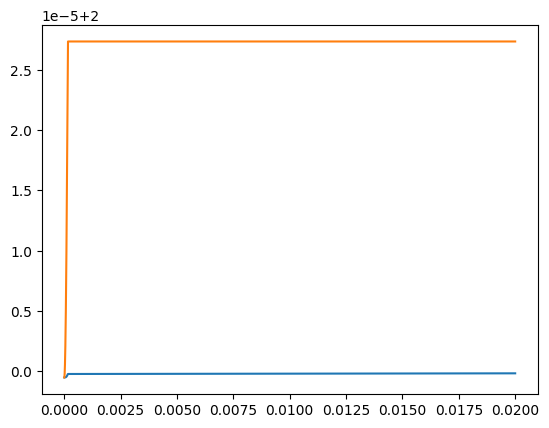

In [ ]:
DataOut = column_stack((t[1:],Ph[1:]-Ph[1],Z_m[1:],-Sp[1:]))
savetxt('SpinBattery50Hznewdataallval.csv', DataOut)